In [78]:
import random
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from utilities import readHomer
from collections import defaultdict
from statsmodels.stats.multitest import fdrcorrection

In [79]:
file = '/media/stephen/Data/HiC-subsample/example/analysis/dat/HiCcompare/chr3L/3000/G1S-vs-AS-logFC-full.homer'

In [80]:
mat = readHomer(file, diagonal=True, sparse=False)
chrom = mat.attrs['chrom']
binSize = mat.attrs['binSize']
nBins = int(np.sqrt(len(mat)))

In [81]:
mat['seperation'] = (mat['start'] - mat['start2']).abs()
mat = mat.loc[abs(mat['seperation']) < 1000000]

In [82]:
# Find and drop bins with a high proportion of missing values
binZeros = mat.groupby('start')['score'].apply(lambda x: sum(x==0) / len(x))
dropBins = binZeros[binZeros > 0.8].index
dropRows = mat['start'].isin(dropBins) | mat['start2'].isin(dropBins)
mat = mat.loc[~dropRows]

In [83]:
mat

,start,start2,score,seperation
342,5503000,5503000,-0.142257,0
343,5503000,5506000,-0.154687,3000
344,5503000,5509000,-0.131432,6000
345,5503000,5512000,0.226020,9000
346,5503000,5515000,0.226020,12000
...,...,...,...,...
28382,5995000,5983000,-0.066327,12000
28383,5995000,5986000,-0.158114,9000
28384,5995000,5989000,-0.206517,6000
28385,5995000,5992000,-0.281378,3000


In [84]:

mat['abs(score)'] = abs(mat['score'])
summed = mat.groupby('start')[['abs(score)', 'score']].sum()

In [100]:
pd.qcut(summed['abs(score)'], 20, labels=range(100, 0, -5))

start
5503000     85
5506000     70
5509000     70
5512000     55
5515000     35
          ... 
5983000     85
5986000     90
5989000     75
5992000     80
5995000    100
Name: abs(score), Length: 161, dtype: category
Categories (20, int64): [100 < 95 < 90 < 85 ... 20 < 15 < 10 < 5]

In [98]:
summed['abs(score)'].describe()

count    161.000000
mean      36.612314
std       14.523994
min       14.906685
25%       24.941975
50%       34.150363
75%       44.103897
max       87.283187
Name: abs(score), dtype: float64

In [41]:
test = []
summed = mat.groupby('start')[['abs(score)', 'score']].sum()
random.seed(42)
nShadow = 1000
summed['shadowSum'] = 0
summed['shadowSumX2'] = 0
for _ in range(nShadow):
    mat['randomScore'] = mat.groupby('seperation')['abs(score)'].transform(np.random.permutation)
    shadowMat = mat.groupby('start')['randomScore'].sum()
    test.append(shadowMat.iloc[10])
    summed['shadowSum'] += shadowMat
    summed['shadowSumX2'] += shadowMat * shadowMat
summed = summed.reset_index()

<AxesSubplot:ylabel='Count'>

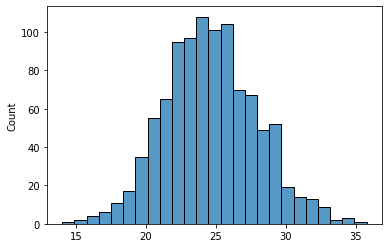

In [42]:
sns.histplot(test)

In [32]:
mat[mat['start2'] == 5497000]

,start,start2,score,seperation,up,abs(score),randomScore
0,5497000,5497000,0.0,0,False,0.0,0.085576
170,5500000,5497000,0.0,3000,False,0.0,0.218920
340,5503000,5497000,0.0,6000,False,0.0,0.053315
510,5506000,5497000,0.0,9000,False,0.0,0.019289
680,5509000,5497000,0.0,12000,False,0.0,0.211804
...,...,...,...,...,...,...,...
28050,5992000,5497000,0.0,495000,False,0.0,0.000000
28220,5995000,5497000,0.0,498000,False,0.0,0.000000
28390,5998000,5497000,0.0,501000,False,0.0,0.000000
28560,6001000,5497000,0.0,504000,False,0.0,0.000000


In [303]:
summed['shadowMean'] = summed['shadowSum'] / nShadow
summed['shadowStd'] = np.sqrt((summed['shadowSumX2'] / nShadow) - (summed['shadowMean'] * summed['shadowMean'])) 

In [304]:
summed['Z'] = (summed['score'] - summed['shadowMean']) / summed['shadowStd']

In [317]:
summed['p'] = stats.norm.sf(abs(summed['Z'])) * 2

In [318]:
intervals = pd.interval_range(0, 1, 20, closed='right')
summed['pBin'] = pd.cut(summed['p'], bins=intervals)

In [349]:
summed['fdr'] = fdrcorrection(summed['p'])[1]

In [354]:
summedFilter = summed.loc[abs(summed['fdr']) > 0.05].copy()

In [355]:
summedFilter['significant'] = summedFilter.apply(
    lambda x: 1 if x['fdr'] > 0 else -1, axis=1)

In [356]:
summedFilter['name'] = '.'

In [347]:
summed['chrom'] = chrom
summed['end'] = summed['start'] + binSize
summed.reset_index()[['chrom', 'start', 'end', 'pScore']]

,chrom,start,end,pScore
0,3L,5497000,5500000,0.30
1,3L,5500000,5503000,0.95
2,3L,5503000,5506000,0.95
3,3L,5506000,5509000,0.95
4,3L,5509000,5512000,0.95
...,...,...,...,...
165,3L,5992000,5995000,0.95
166,3L,5995000,5998000,0.95
167,3L,5998000,6001000,0.75
168,3L,6001000,6004000,0.40


In [283]:
summed.reset_index()[['start', 'end']]

,start,end
0,5497000,5500000
1,5500000,5503000
2,5503000,5506000
3,5506000,5509000
4,5509000,5512000
...,...,...
165,5992000,5995000
166,5995000,5998000
167,5998000,6001000
168,6001000,6004000
